In [1]:
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\Meghna\AppData\Local\Temp\ipykernel_4456\2811383184.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
n_samples=1000
X,y=make_circles(n_samples,noise=0.03,random_state=42)
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [3]:
circles=pd.DataFrame({ "x1":X[:,0],
                      "x2":X[:,1],
                      "label":y
})
circles.head(10)

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

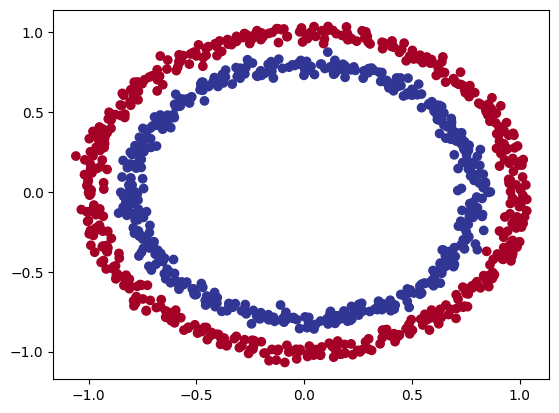

In [5]:
plt.scatter(x=X[:,0],
           y=X[:,1],
           c=y,
           cmap=plt.cm.RdYlBu)

In [6]:
X.shape,y.shape

((1000, 2), (1000,))

In [7]:
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

In [8]:
X,y[:3]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         ...,
         [-0.1369, -0.8100],
         [ 0.6704, -0.7675],
         [ 0.2811,  0.9638]]),
 tensor([1., 1., 1.]))

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [10]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 =nn.Linear(in_features=2,out_features=5)
        self.layer_2=nn.Linear(in_features=5,out_features=1)
    def forward(self,X):
        return self.layer_2(self.layer_1(X))
model_01=CircleModel().to(device)
model_01

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
untrained_preds = model_01(X_test.to(device))

In [13]:
print(len(untrained_preds), untrained_preds.shape)
print(len(y_test),y_test.shape)

200 torch.Size([200, 1])
200 torch.Size([200])


In [14]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_01.parameters(),lr=0.1)

In [15]:
def accuracy(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [16]:
#raw outputs of our model
model_01.eval()
with torch.inference_mode():
    y_logits = model_01(X_test.to(device))[:5]
y_logits

tensor([[0.3147],
        [0.4611],
        [0.0636],
        [0.3853],
        [0.2743]])

In [17]:
#these are prediction probabilities 
#y_pred_logits>=0.5 -->class 1
#y_pred_logits<0.5 -->class0
y_pred_logits = torch.sigmoid(y_logits)
y_pred_logits[:5]

tensor([[0.5780],
        [0.6133],
        [0.5159],
        [0.5951],
        [0.5682]])

In [18]:
#To turn our prediction probabilities in prediction labels
y_pred = torch.round(y_pred_logits)
y_pred_labels = torch.round(torch.sigmoid(model_01(X_test.to(device))[:5]))
print(torch.eq(y_pred.squeeze(),y_pred_labels.squeeze()))
# squeeze: to remove extra dimension
y_pred.squeeze().shape

tensor([True, True, True, True, True])


torch.Size([5])

In [19]:
 y_test[:5].shape
# Now shape of output from the model==  required output shape

torch.Size([5])

In [20]:
#Building Training and Testing Loop
torch.manual_seed(42)
epochs =100
for epoch in range(epochs):
    model_01.train()
    y_logits = model_01(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits,y_train)
    acc = accuracy(y_true=y_train,y_pred = y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_01.eval()
    with torch.inference_mode():
        test_logits = model_01(X_test).squeeze()
        test_pred= torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy(y_true = y_test, y_pred = test_pred)
    if epoch%10==0:
        print(f"Epoch:{epoch}| loss:{loss}, accuracy:{acc} | test_loss:{test_loss}, test_accuracy:{test_acc}")
        


Epoch:0| loss:0.7069512009620667, accuracy:53.37499999999999 | test_loss:0.7147804498672485, test_accuracy:54.50000000000001
Epoch:10| loss:0.6997707486152649, accuracy:54.87499999999999 | test_loss:0.7068477869033813, test_accuracy:49.5
Epoch:20| loss:0.6969572305679321, accuracy:53.25 | test_loss:0.7034072875976562, test_accuracy:48.0
Epoch:30| loss:0.6956511735916138, accuracy:52.75 | test_loss:0.7016196250915527, test_accuracy:47.0
Epoch:40| loss:0.6949320435523987, accuracy:52.37500000000001 | test_loss:0.7005254626274109, test_accuracy:47.0
Epoch:50| loss:0.6944774389266968, accuracy:51.0 | test_loss:0.6997673511505127, test_accuracy:48.0
Epoch:60| loss:0.6941624283790588, accuracy:51.24999999999999 | test_loss:0.699196457862854, test_accuracy:48.0
Epoch:70| loss:0.6939316391944885, accuracy:50.875 | test_loss:0.6987424492835999, test_accuracy:47.0
Epoch:80| loss:0.6937568783760071, accuracy:51.125 | test_loss:0.6983680129051208, test_accuracy:46.5
Epoch:90| loss:0.69362139701843

In [21]:
import requests
from pathlib import Path 
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


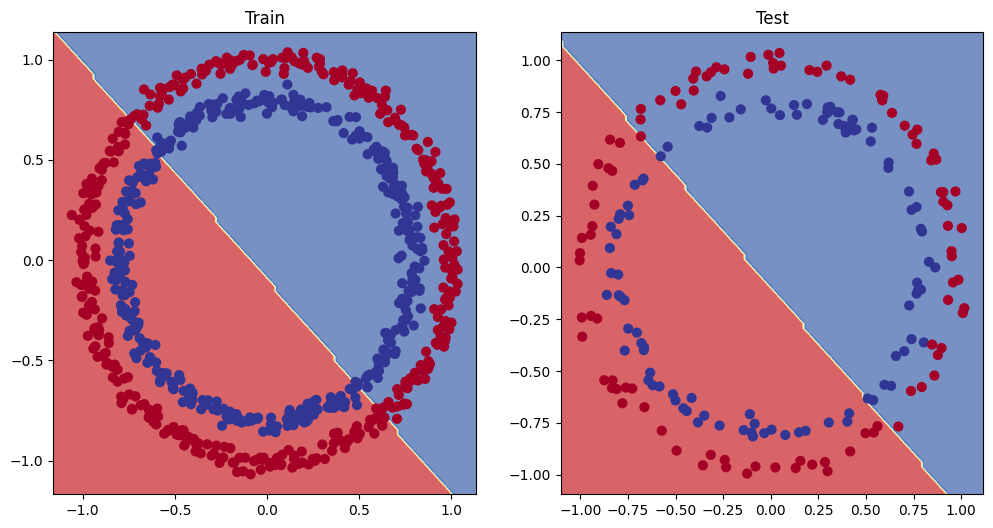

In [22]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_01, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_01, X_test, y_test)

In [27]:
# We cannot clasi=sify these two classes using a linear  line or straight line
# Hence we need to improve the model 
class CircleModelNew(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1=nn.Linear(in_features=2, out_features=20)
        self.layer_2=nn.Linear(in_features=20, out_features=20)
        self.layer_3=nn.Linear(in_features=20, out_features=1)
        
        self.relu=nn.ReLU()
    def forward(self,X):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(X)))))

        
model_02 = CircleModelNew().to(device)
print(model_02)

CircleModelNew(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)


In [28]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_02.parameters(), lr=0.1)

In [29]:
torch.manual_seed(42)
epochs = 1000
for epoch in range(epochs):
    y_logits = model_02(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) 
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy(y_true=y_train, 
                      y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_02.eval()
    with torch.inference_mode():
      test_logits = model_02(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) 
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy(y_true=y_test,
                             y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69448, Accuracy: 47.62% | Test Loss: 0.69197, Test Accuracy: 54.00%
Epoch: 100 | Loss: 0.69102, Accuracy: 53.12% | Test Loss: 0.68961, Test Accuracy: 56.50%
Epoch: 200 | Loss: 0.68750, Accuracy: 56.88% | Test Loss: 0.68704, Test Accuracy: 57.00%
Epoch: 300 | Loss: 0.68379, Accuracy: 59.62% | Test Loss: 0.68357, Test Accuracy: 59.50%
Epoch: 400 | Loss: 0.67821, Accuracy: 63.12% | Test Loss: 0.67807, Test Accuracy: 63.00%
Epoch: 500 | Loss: 0.66898, Accuracy: 69.50% | Test Loss: 0.66913, Test Accuracy: 72.00%
Epoch: 600 | Loss: 0.65292, Accuracy: 75.38% | Test Loss: 0.65433, Test Accuracy: 77.00%
Epoch: 700 | Loss: 0.62314, Accuracy: 85.62% | Test Loss: 0.62753, Test Accuracy: 84.00%
Epoch: 800 | Loss: 0.56539, Accuracy: 94.62% | Test Loss: 0.57623, Test Accuracy: 94.00%
Epoch: 900 | Loss: 0.45988, Accuracy: 99.38% | Test Loss: 0.48168, Test Accuracy: 98.00%


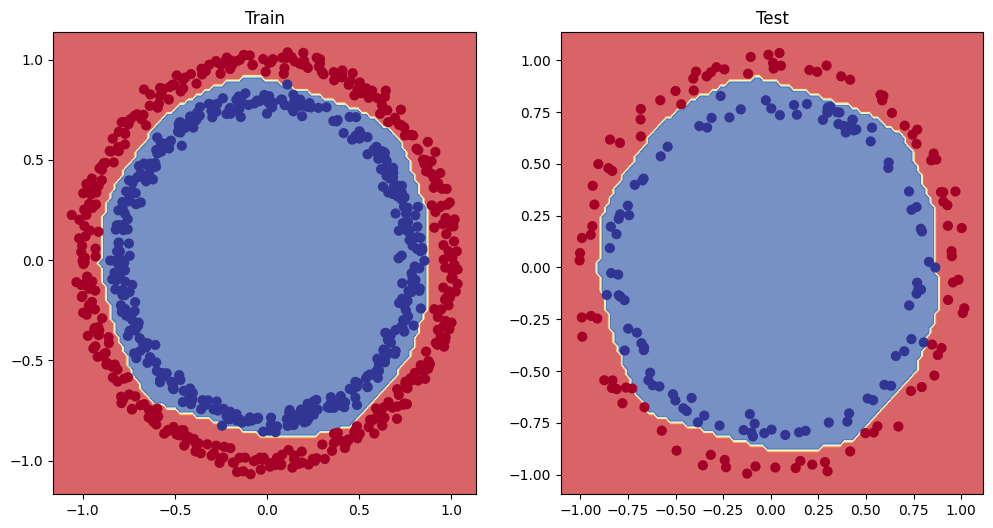

In [30]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_02, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_02, X_test, y_test) # model_3 = has non-linearity